In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid")

In [1]:
comment = """RUNNING - Modelling with Location-Specific Feature Engineered data.
This script will run the model training for location-specific feature engineered data
that I have generated in previous notebook
NOTE: This script needs the output files of 1.4-sm-feature-engineering-location 
AND it will fail for the downsampled dataset.
"""
print(comment)
from time import sleep
sleep(5)

RUNNING - Modelling with Location-Specific Feature Engineered data.
This script will run the model training for location-specific feature engineered data
that I have generated in previous notebook


# Obtain Data

In [27]:
from scipy.sparse import csr_matrix, load_npz

In [28]:
train = load_npz('1.4-sm-feature-engineered-location.npz')
# train = pd.read_csv('1.1-am-feature-engineered-1.csv')

In [29]:
train.shape

(31758, 1137)

In [30]:
labels = pd.read_csv('1.4-sm-feature-engineered-location-labels.csv', )

In [31]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31758 entries, 0 to 31757
Data columns (total 1 columns):
stars    31758 non-null int64
dtypes: int64(1)
memory usage: 248.2 KB


In [32]:
labels.stars.values

array([8, 5, 8, ..., 5, 8, 6])

### Modelling label as binary

Here I am defining the success measure of a restaurant as being a star rating of >= 3.5 (i.e. label >=7)

In [33]:
labels = labels >= 7

In [34]:
labels = labels.astype(np.int)

In [35]:
labels.stars.value_counts()

1    20484
0    11274
Name: stars, dtype: int64

# Setup for Modelling

## Splitting data

In [36]:
X = train
y = labels.stars.values

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_cv, y_train, y_cv = train_test_split( 
              X, y, test_size = 0.4, random_state = 42, stratify = y) 

In [39]:
X_cv, X_test, y_cv, y_test = train_test_split(X_cv, y_cv, test_size=0.1, random_state=42, stratify=y_cv)

In [40]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(19054, 1137)
(11433, 1137)
(1271, 1137)


In [41]:
y_train

array([0, 1, 0, ..., 0, 1, 0])

## Training Function

In [42]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [43]:
def trainModelGrid(estimator, params, train, y, cv=5):
    model = GridSearchCV(estimator, params, n_jobs=-1, scoring='accuracy',cv=cv)
    model.fit(train, y)
    return model

In [44]:
def trainModelRandom(estimator, params, train, y, cv=5, n_iter=5):
    model = RandomizedSearchCV(estimator, params, n_jobs=-1, scoring='accuracy',cv=cv, n_iter=n_iter)
    model.fit(train, y)
    return model

# Modelling

## Lasso Regression

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
logreg = LogisticRegression(penalty='l1', dual=False, solver='liblinear', random_state=0)

In [47]:
import scipy.stats as st

In [48]:
params_dist = {  
    "max_iter": st.randint(100,300),
    "C": st.uniform(1.1, 3.0)
}
params_grid = {  
    "max_iter": [200, 210, 220],
    "C": [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
}

In [49]:
%%time 
model = trainModelRandom(logreg, params_dist, X_train, y_train)

CPU times: user 698 ms, sys: 141 ms, total: 840 ms
Wall time: 7.72 s


In [50]:
model.best_score_

0.658811798047654

In [51]:
model.best_estimator_

LogisticRegression(C=1.9000161006989842, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=258,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [52]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
accuracy_score(y_cv, cvPredicted)

0.6552086066649173

## Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
dt = DecisionTreeClassifier(random_state=0)

In [57]:
params_grid = {
    "max_depth" : np.arange(1, 25, 1)
}

In [58]:
%%time
model = trainModelGrid(dt, params_grid, X_train, y_train)

CPU times: user 511 ms, sys: 110 ms, total: 622 ms
Wall time: 11.7 s


In [59]:
model.best_score_

0.6980686470032539

In [60]:
model.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [61]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [62]:
accuracy_score(y_cv, cvPredicted)

0.6921193037697893

In [63]:
model.cv_results_['mean_test_score']

array([0.6426997 , 0.68667996, 0.69418495, 0.6952346 , 0.69303033,
       0.69623176, 0.69806865, 0.69245303, 0.69397502, 0.68893671,
       0.68573528, 0.67628844, 0.67529128, 0.67508135, 0.67182744,
       0.66930828, 0.66531962, 0.6644799 , 0.66274798, 0.65933662,
       0.65734229, 0.65519051, 0.65188412, 0.65151674])

In [64]:
np.argmax(model.cv_results_['mean_test_score'])

6

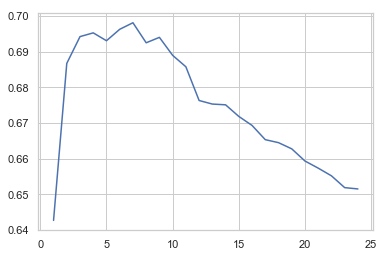

In [65]:
sns.lineplot(x=np.arange(1,25,1), y=model.cv_results_['mean_test_score'])

In [66]:
model.best_estimator_.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [67]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

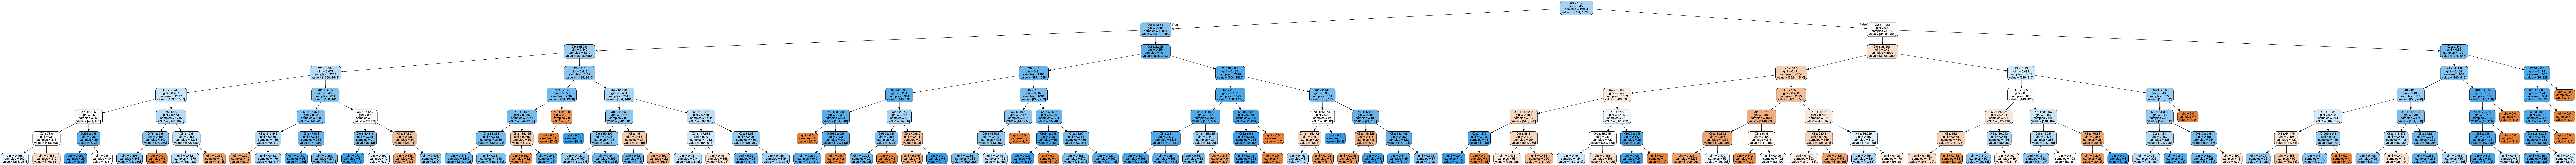

In [68]:
dot_data = StringIO()

export_graphviz(model.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('../models/dtree-graph.png')
Image(graph.create_png())

## Gradient Boosted Trees

In [69]:
from xgboost.sklearn import XGBClassifier

In [70]:
xgb = XGBClassifier(random_state=0)

In [71]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params_dist = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

In [72]:
%%time
model = trainModelRandom(xgb, params_dist, X_train, y_train, cv=20, n_iter=50)

CPU times: user 3.86 s, sys: 480 ms, total: 4.34 s
Wall time: 2min 33s


In [73]:
model.best_score_

0.7100871208145272

In [74]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7872849742803661, gamma=3.292578421832195,
       learning_rate=0.2546551659485287, max_delta_step=0, max_depth=32,
       min_child_weight=38.57473872860071, missing=None, n_estimators=31,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=5.402360839696431, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9751071719528706)

In [75]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [76]:
accuracy_score(y_cv, cvPredicted)

0.7026152365958191

## Random Forest Classifier

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rf = RandomForestClassifier(random_state=0)

In [79]:
params_dist = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40)
}

In [80]:
%%time
model = trainModelRandom(rf, params_dist, X_train, y_train)

CPU times: user 974 ms, sys: 28.8 ms, total: 1 s
Wall time: 3.3 s


In [81]:
model.best_score_

0.688254434764354

In [82]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [83]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [84]:
accuracy_score(y_cv, cvPredicted)

0.6767252689582787

## Support Vector Classifier

In [85]:
from sklearn.svm import LinearSVC

In [86]:
svc = LinearSVC(dual=False, random_state=0)

In [87]:
params = {  
    "C": [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
}

In [88]:
params_dist = {  
    "C": st.uniform(1.0, 2.0)
}

In [89]:
%%time
model = trainModelRandom(svc, params_dist, X_train, y_train)

CPU times: user 392 ms, sys: 29.8 ms, total: 422 ms
Wall time: 3.31 s


In [90]:
model.best_score_

0.6610685420384171

In [91]:
model.best_estimator_

LinearSVC(C=2.4276214441633277, class_weight=None, dual=False,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0)

In [92]:
cvPredicted = model.best_estimator_.predict(X_cv)

In [93]:
accuracy_score(y_cv, cvPredicted)

0.6602816408641652